# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(21, 21)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [8]:
buy_price_df = econ_sim.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = econ_sim.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = econ_sim.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = econ_sim.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = econ_sim.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [9]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [11]:
cannot_buy_df = econ_sim.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = econ_sim.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

# Transactions

## Market Overview

In [12]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,36655.0,1.567773e+05
1,39124.0,5.844127e+05
2,29187.0,7.210621e+05
3,36647.0,3.161024e+06
4,39116.0,4.670228e+06
5,29174.0,7.654564e+05
6,1354.0,7.744510e+06
7,1841.0,5.532627e+06
8,937.0,4.356666e+06


Text(0.5, 1.0, 'transaction count by tick')

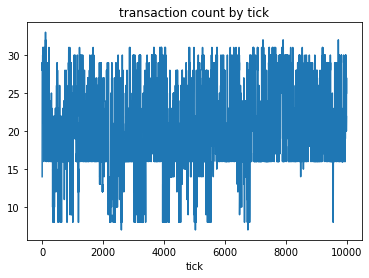

In [13]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

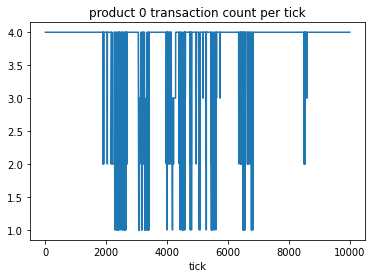

In [14]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

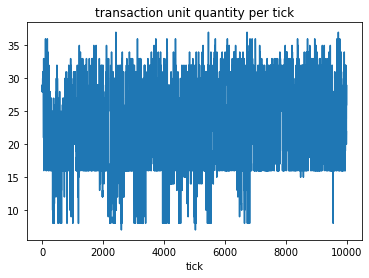

In [15]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

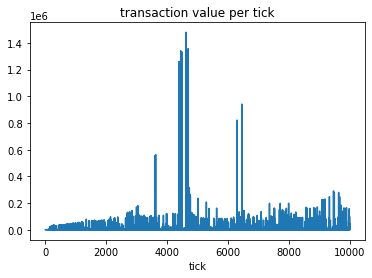

In [16]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

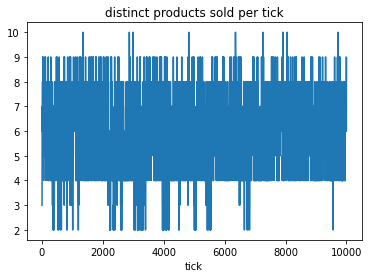

In [17]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

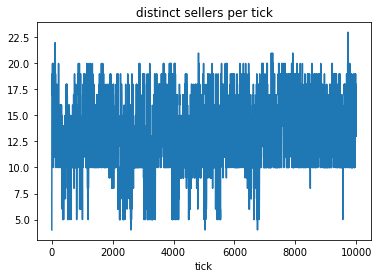

In [18]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

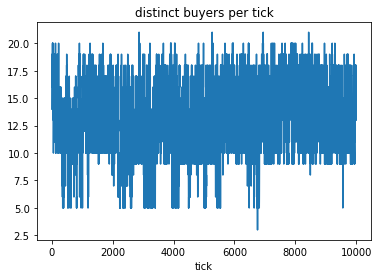

In [19]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [20]:
transaction_df["seller"].nunique()

80

In [21]:
transaction_df["buyer"].nunique()

85

In [22]:
transaction_df["product"].nunique()

18

<AxesSubplot:>

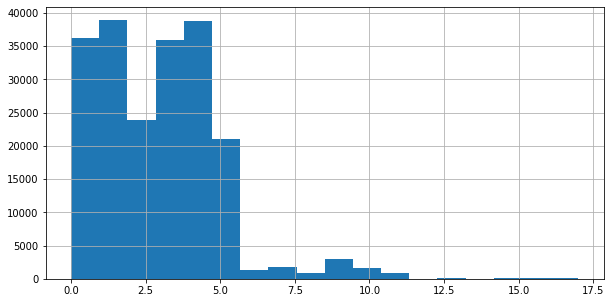

In [23]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

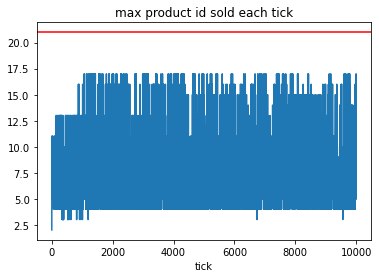

In [24]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [25]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    9013.000000
mean       87.620633
std       145.398426
min         4.169206
25%         5.941156
50%        15.201606
75%        71.769495
max       860.034970
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

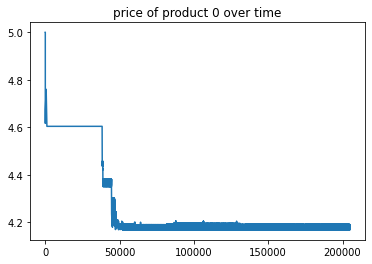

In [26]:
transaction_df[transaction_df["seller"] == 0]["price"].plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 2 over time')

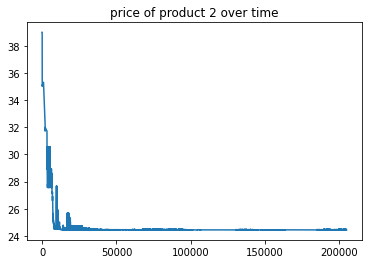

In [27]:
transaction_df[transaction_df["seller"] == 2]["price"].plot()
plt.title("price of product 2 over time")

Text(0.5, 1.0, 'price of product 6 over time')

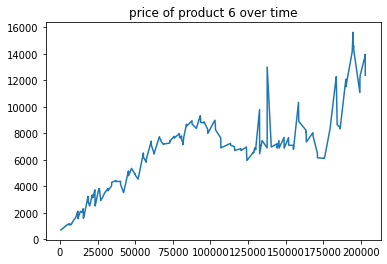

In [28]:
transaction_df[transaction_df["seller"] == 6]["price"].plot()
plt.title("price of product 6 over time")

<AxesSubplot:>

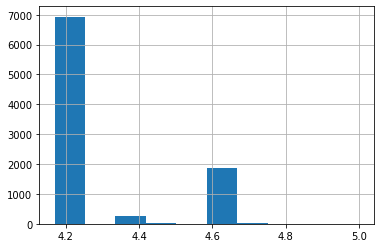

In [29]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

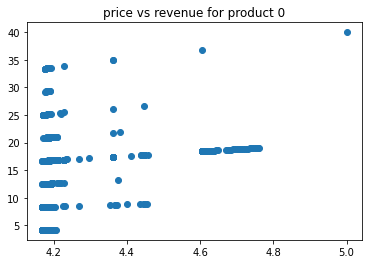

In [30]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

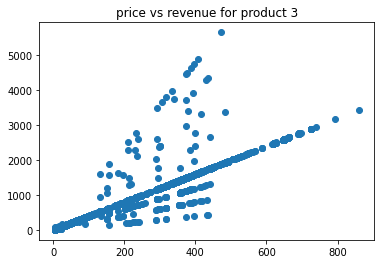

In [31]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [32]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value


## Transaction Graph

In [33]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,3,0,6154.0
1,3,58,3043.0
2,3,80,3.0
3,3,89,1.0
4,4,1,6466.0
...,...,...,...
796,99,69,1.0
797,99,70,6.0
798,99,84,1.0
799,99,90,7.0


In [34]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [35]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [36]:
G = nx.relabel_nodes(G, labels)

In [37]:
nx.is_directed_acyclic_graph(G)

True

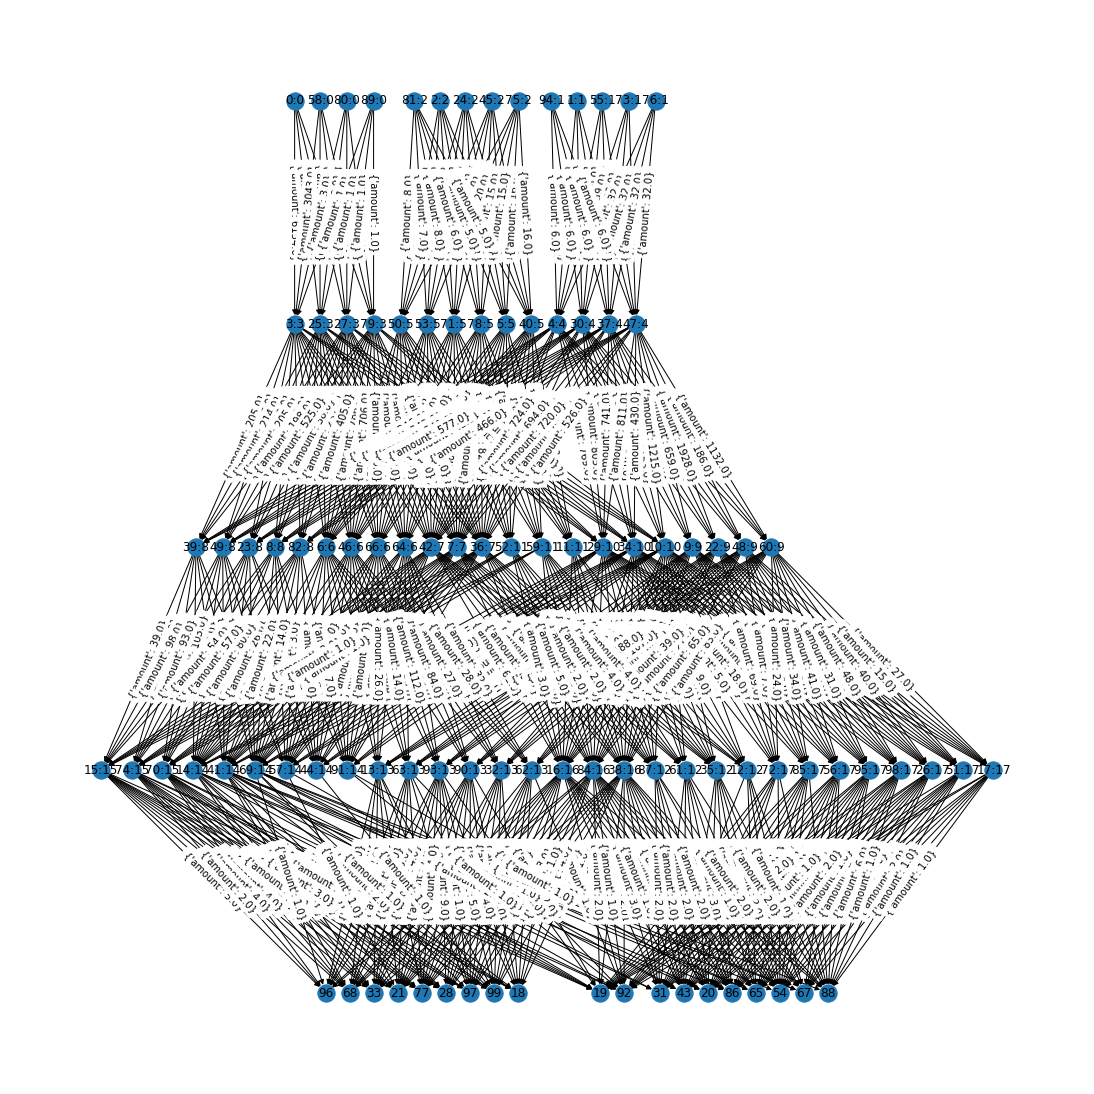

In [38]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

# Balance

In [39]:
balance_df = econ_sim.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [40]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,2.083131e+02
1,0,9.995821e+02
2,0,1.705584e+03
3,0,4.000000e+02
4,0,1.750000e+03
...,...,...
95,0,2.560000e+05
96,0,2.043402e+08
97,0,2.043402e+08


In [41]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,10000,2.857544e+03
1,10000,1.272315e+05
2,10000,5.708846e+03
3,10000,7.726746e+05
4,10000,1.041143e+06
...,...,...
95,10000,4.103369e+05
96,10000,2.006052e+08
97,10000,2.004743e+08


In [42]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [43]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    1.000000e+02
mean     3.282097e+07
std      1.060212e+08
min      2.083131e+02
25%      2.900000e+03
50%      3.940000e+04
75%      1.283550e+06
max      6.491939e+08
Name: balance, dtype: float64

In [44]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    1.000000e+02
mean     3.283145e+07
std      1.050910e+08
min      2.100673e+02
25%      1.115083e+05
50%      1.011100e+06
75%      2.112024e+06
max      6.470664e+08
Name: balance, dtype: float64

In [45]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

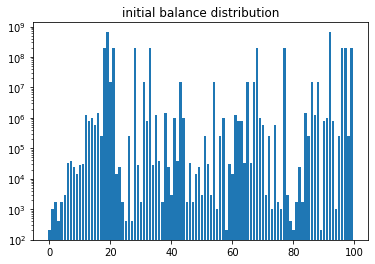

In [46]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

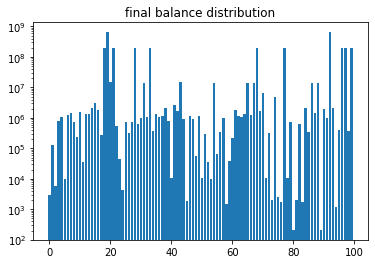

In [47]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [48]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0     2.649231e+03
1     1.262319e+05
2     4.003262e+03
3     7.722746e+05
4     1.039393e+06
          ...     
95    1.543369e+05
96   -3.734916e+06
97   -3.865898e+06
98    1.111573e+05
99   -3.130959e+06
Name: balance, Length: 100, dtype: float64

In [49]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0     2.857544e+03
1     1.272315e+05
2     5.708846e+03
3     7.726746e+05
4     1.041143e+06
          ...     
95    4.103369e+05
96    2.006052e+08
97    2.004743e+08
98    3.671573e+05
99    2.012092e+08
Name: balance, Length: 100, dtype: float64

In [50]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
1000000,0,10000,2.857544e+03
1000001,1,10000,1.272315e+05
1000002,2,10000,5.708846e+03
1000003,3,10000,7.726746e+05
1000004,4,10000,1.041143e+06
1000005,5,10000,9.925715e+03
1000006,6,10000,1.236546e+06
1000007,7,10000,1.417114e+06
1000008,8,10000,7.503051e+05
1000009,9,10000,2.427903e+05


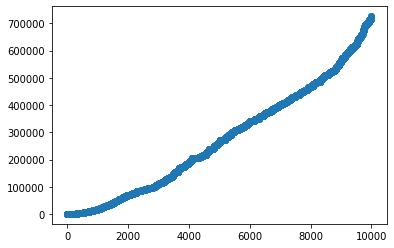

In [51]:
plt.scatter(balance_df[balance_df["agent"] == 23]["tick"],balance_df[balance_df["agent"] == 25]["balance"])

In [52]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [53]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,13.717543
1,127.284719
2,3.347151
3,1931.686569
4,594.938772
...,...
95,1.602879
96,0.981722
97,0.981081


# Inventory

In [54]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = econ_sim.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

## Last Tick Inventory

In [55]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
1000000,0,10000,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000001,1,10000,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000002,2,10000,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003,3,10000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000004,4,10000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000095,95,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000096,96,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,1.0,10.0,5.0,0.0,0.0,0.0,0.0
1000097,97,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.0,2.0,11.0,5.0,0.0,0.0,0.0,0.0
1000098,98,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [56]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,tick
0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [57]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,1.0,10.0,5.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,2.0,11.0,5.0,0.0,0.0,0.0,0.0,NaN


In [58]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-15.0,-23.0,-32.0,-5.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-14.0,-22.0,-31.0,-5.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [63]:
agent_id = 16
inv_s = inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent").loc[agent_id].drop("tick")
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,NaN
7,0.0,5.0,5.0,-5.0,0.0
8,0.0,0.0,0.0,0.0,NaN
9,12.0,6.0,6.0,6.0,2.0


In [64]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == balance_df["tick"].max())]

,agent,tick,balance
1000016,16,10000,1.809570e+06


In [65]:
buy_budget_df[(buy_budget_df["tick"] == buy_budget_df["tick"].max()) & (buy_budget_df["agent"] == agent_id)].T

,1000016
agent,16.000000
tick,10000.000000
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,30103.952141


In [66]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count    10001.000000
mean         0.031997
std          0.238697
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: 16, dtype: float64

# Buy and Sell Prices

In [67]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     4.168690e+00
1     1.004179e+01
2     2.444163e+01
3     7.342046e+00
4     1.429670e+01
5     2.444511e+01
6     6.590642e+03
7     2.042602e+03
8     1.125182e+03
9     4.346472e+02
10    1.733349e+03
11    1.494907e+02
12    6.003857e+04
13    8.148255e+04
14    9.258435e+04
15    6.935989e+04
16    3.905010e+04
17    1.685784e+04
18    1.487967e+07
19    9.012175e+07
20    9.633015e+05
dtype: float64

## Market Analysis for one Good

In [68]:
product_id = 18
min_ticks = 0
max_ticks = np.inf

df1 = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))].groupby("tick")[product_id].min().to_frame().reset_index()
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks, max_ticks))].groupby("tick")[product_id].min().to_frame().reset_index()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[buy_budget_df[product_id] > 0][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


0.0


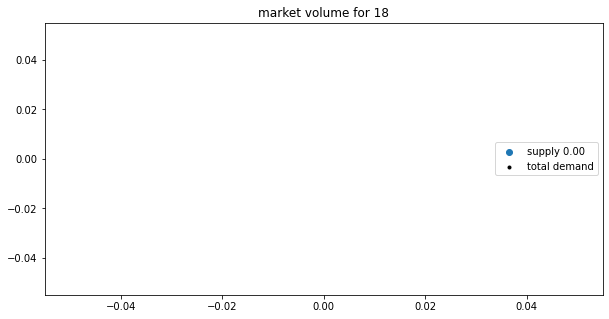

In [69]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

Text(0.5, 1.0, 'price chart for 18')

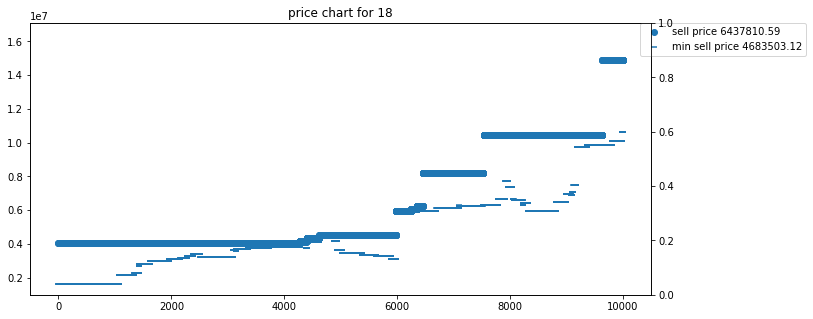

In [70]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1["tick"], df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(dfms["tick"], dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
ax2.vlines((buyer_df.groupby("tick")["units"].sum() > 0).index, ymin=0.94, ymax=0.96, color="darkred")
ax2.vlines(df1[(df2.groupby("tick")[product_id].max() - df1[product_id])>0].index, ymin=0.92, ymax=0.94, color="darkgreen")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

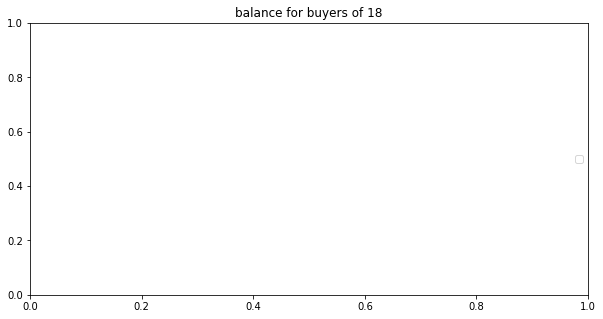

In [71]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [72]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["amount"].sum()

Series([], Name: amount, dtype: float64)

In [73]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max


In [74]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max


### Buy/Sell Price Investigation

In [75]:
df1[product_id].describe()

count    1.000100e+04
mean     6.437811e+06
std      3.066862e+06
min      4.086803e+06
25%      4.086803e+06
50%      4.561582e+06
75%      8.225733e+06
max      1.487967e+07
Name: 18, dtype: float64

In [76]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max


In [77]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

nan

In [78]:
(df2.groupby("tick")[product_id].max() - df1.set_index("tick")[product_id]).describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 18, dtype: float64

In [79]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

nan

In [80]:
(dfmb.groupby("tick")[product_id].max() - dfms.set_index("tick")[product_id]).describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 18, dtype: float64

In [81]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
18,1.651140e+06,2.809647e+06,4.086803e+06,1.651124e+06,2.435663e+06
118,1.622610e+06,4.086803e+06,4.086803e+06,1.651140e+06,2.464193e+06
218,1.629449e+06,4.086803e+06,4.086803e+06,1.651140e+06,2.457354e+06
318,1.636323e+06,4.086803e+06,4.086803e+06,1.651140e+06,2.450480e+06
418,1.643231e+06,4.086803e+06,4.086803e+06,1.651140e+06,2.443572e+06
...,...,...,...,...,...
999618,5.658140e+06,5.658140e+06,6.410031e+07,1.062737e+07,5.844217e+07
999718,5.663798e+06,5.663798e+06,6.410031e+07,1.062737e+07,5.843651e+07
999818,5.669462e+06,5.669462e+06,6.410031e+07,1.062737e+07,5.843085e+07
999918,5.675131e+06,5.675131e+06,6.410031e+07,1.062737e+07,5.842518e+07


## Larger Scale Market Analysis

In [82]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

In [83]:
demand_units_df.shape

(1000100, 21)

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [167]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

product
0     3.6655
1     3.9124
2     2.9187
3     3.6647
4     3.9116
5     2.9174
6     0.1354
7     0.1841
8     0.0937
9     0.3112
10    0.1589
11    0.1182
12    0.0044
13    0.0141
14    0.0039
15    0.0107
16    0.0105
17    0.0149
Name: amount, dtype: float64

In [159]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

,supply,supply_cv,demand,demand_cv,surplus,min_input_surplus
0,37.065493,4.931505,3.750325,0.288266,33.315168,0.000000
1,46.419158,4.379025,3.912809,0.152659,42.506349,0.000000
2,62.993201,3.994983,2.949605,1.031296,60.043596,0.000000
3,4.533347,5.036461,91.497550,0.210426,-86.964204,33.315168
4,4.177182,4.928930,66.678432,0.475859,-62.501250,42.506349
5,12.059894,4.025245,40.878912,0.387645,-28.819018,60.043596
6,0.135386,6.972369,106.625937,0.122674,-106.490551,-9.662689
7,0.270573,10.117066,124.741126,0.251893,-124.470553,-17.392841
8,0.244276,15.966112,54.889811,0.286124,-54.645535,-14.494034
9,1.301070,10.127945,136.664534,0.250864,-135.363464,-12.500250


In [163]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

0       33.315168
1       42.506349
2       60.043596
3      -53.649035
4      -19.994901
5       31.224578
6     -116.153240
7     -141.863394
8      -69.139569
9     -147.863714
10    -140.011182
11     -47.293621
12     -43.209403
13    -667.622014
14    -703.923350
15   -1098.365027
16    -792.636122
17   -3459.590226
18     -76.753269
19     -12.689511
20    -284.812398
dtype: float64

In [157]:
pd.DataFrame(production_chain.adj_matrix)[11]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     6.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
Name: 11, dtype: float64

## Cannot Buy or Sell

<AxesSubplot:>

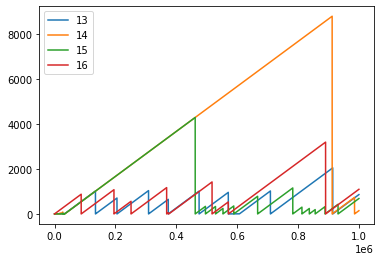

In [110]:
cannot_buy_df[cannot_buy_df["agent"] == 18][[13,14,15,16]].plot()

# Profit Analysis

In [87]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [88]:
costs

buyer
0     0.000000e+00
1     0.000000e+00
2     0.000000e+00
3     3.924661e+04
4     1.490743e+05
          ...     
95    3.344704e+05
96    3.734916e+06
97    3.865898e+06
98    3.975228e+05
99    3.130959e+06
Name: value, Length: 100, dtype: float64

In [90]:
revenue

seller
0     1.046988e+05
1     3.858524e+05
2     4.793930e+05
3     8.115212e+05
4     1.188467e+06
          ...     
95    4.888073e+05
96    0.000000e+00
97    0.000000e+00
98    5.086801e+05
99    0.000000e+00
Name: value, Length: 100, dtype: float64

In [91]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)

In [92]:
((revenue - costs) + value_of_goods_on_hand)

seller
0     1.047405e+05
1     3.859376e+05
2     4.794908e+05
3     7.729696e+05
4     1.039459e+06
          ...     
95    1.574790e+05
96   -8.037411e+05
97   -5.604395e+05
98    1.277459e+05
99    8.246661e+05
Length: 100, dtype: float64

<AxesSubplot:>

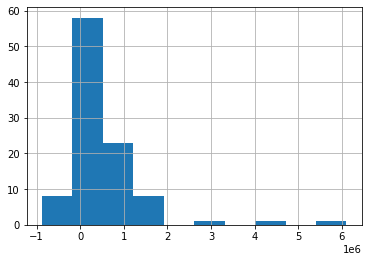

In [93]:
((revenue - costs) + value_of_goobds_on_hand).hist()

In [103]:
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

(array([19, 20, 21, 43, 68, 77, 92, 96, 97]),)

In [107]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

19    19
20    20
21    18
43    20
68    18
77    18
92    19
96    18
97    18
dtype: int64

In [96]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

agent
0     2.649231e+03
1     1.262319e+05
2     4.003262e+03
3     7.722746e+05
4     1.039393e+06
          ...     
95    1.543369e+05
96   -3.734916e+06
97   -3.865898e+06
98    1.111573e+05
99   -3.130959e+06
Name: balance, Length: 100, dtype: float64

<AxesSubplot:>

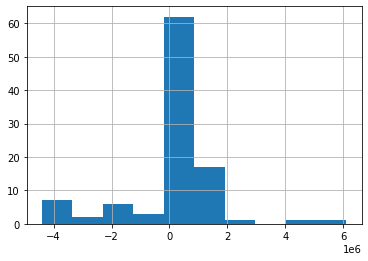

In [97]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

# Production Efficiency

In [95]:
production_efficiency_df = econ_sim.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")